# EGM703 - Week 2 Practical: Hyperspectral image analysis

## Overview
In the lectures and reading this week, you've learned about hyperspectral remote sensing and a number of different methods for analyzing hyperspectral data. In this practical, we'll gain some experience working with hyperspectral data, using a few examples written in python.

## Objectives

- Open and view data using xarray
- Perform atmospheric correction using dark object subtraction
- Use spectral angle matching to compare spectral signatures and identify surfaces
- Gain some familiarity with Spectral Python (SPy), a python package for analyzing hyperspectral images.

## Data provided
In the `data` folder, you should have the following files:

- solar_spectra.csv
- spectral_library.csv

You'll need to download the hyperspectral data from Blackboard, or from the Google Drive link [here](https://drive.google.com/file/d/18EHJpSbkbARJ2Rt6NndBSPe9SlcYr_iO/view?usp=sharing) - be sure to save it to the `data` folder.

## 1 Getting started
As always, we need to run the following cell to import the necessary libraries, as well as define a couple of functions that we'll use for displaying the image(s).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import spectral as spy


def plot_rgb(ax, ds, bands, crs, variable='radiance'):
    """
    Plot an RGB composite of an image using the provided bands.
    
    Parameters
    ----------
    ax - a matplotlib Axes object
    ds - the xarray DataSet with a 'radiance' variable representing the image
    bands - a list of the three bands to display, in R, G, B order
    crs - a CRS object to pass to ax.imshow()
    variable - which variable from ds to show (default: radiance)
    
    Returns
    -------
    ax - the matplotlib Axes object
    """
    dispimg = []
    for b in bands:
        this_band = ds[variable].loc[b].values
        this_band = percentile_stretch(this_band)
        dispimg.append(this_band)
    dispimg = np.array(dispimg)
    ax.imshow(dispimg.transpose([1, 2, 0]), transform=crs, extent=[ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()])
    return ax
    

def percentile_stretch(image, pmin=0., pmax=100.):
    """
    Apply a linear percentile stretch to an image.
    
    Parameters
    ----------
    image - the input image
    pmin - the minimum percentile to use in the stretch
    pmax - the maximum percentile to use in the stretch
    
    Returns
    -------
    stretched - the stretched image band
    """
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
    
    minval = np.percentile(image[image > 0], pmin)
    maxval = np.percentile(image[image > 0], pmax)
    
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
    
    return stretched

### 1.1 Loading the data

The image we'll be using in this practical is an EO-1 Hyperion image, acquired 22 June 2003. The images are terrain-corrected and radiometrically calibrated by the USGS. I have combined them into a single NetCDF file, re-scaled the values to radiance, and removed any bands that don't contain data. For more information about Hyperion images, including the different processing levels, see this [USGS link](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-earth-observing-one-eo-1-hyperion).

`xarray` doesn't automatically read all of the file from the disk. This means that once the image is opened, we also need to load the data using `Dataset.load()` - this is mostly so that we don't have to read the data from the disk every time we want to plot it.

In [2]:
ds = xr.open_dataset('data/EO1H0380352003173110PF.nc')
xmin, ymin, xmax, ymax = ds.x.min(), ds.y.min(), ds.x.max(), ds.y.max()

ds.load() # this will load the entire image into memory - it may take a minute!

<xarray.Dataset>
Dimensions:     (band: 194, x: 1121, y: 3381)
Coordinates:
  * band        (band) uint8 8 9 10 11 12 13 14 ... 218 219 220 221 222 223 224
  * x           (x) float32 2.148e+05 2.148e+05 ... 2.484e+05 2.484e+05
  * y           (y) float32 4.07e+06 4.07e+06 4.07e+06 ... 3.968e+06 3.968e+06
Data variables:
    crs         |S1 b''
    radiance    (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wavelength  (band) float32 426.8 437.0 447.2 ... 2.385e+03 2.396e+03
Attributes:
    Conventions:  CF-1.7
    description:  Georeferenced EO-1 Hyperion image converted to measured rad...
    history:      Created Sun Sep 26 15:10:22 2021
    source:       Robert McNabb (robertmcnabb@gmail.com)

### 1.2 Selecting bands using xarray

Once we have the data loaded, we can start to explore. In the output above, you should see the different coordinates - `band`, `x`, and `y`. You should also see the following data variables:

- `crs`: this is the CRS variable that tells a GIS software how to display the images
- `radiance`: these are the radiance values
- `wavelength`: this is the wavelength corresponding to each band.

Note, for example, that `radiance` has three dimensions: `band`, `y`, and `x`, while `wavelength` has only one: `band`. This also tells the index order for a given value in the `radiance` array: `ds['radiance'][0, 1000, 500]` corresponds to the first band, the 1001st row, and the 501st column.

This can be a little bit confusing here - the first band (index 0) is actually Hyperion Band 8 (because Bands 1-7 have no data). Rather than selecting by the array index, we can select by the `coordinate` - in this case, we would use the actual Hyperion band number. The following should give us information about Band 8:

In [3]:
ds['radiance'].loc[8]

<xarray.DataArray 'radiance' (y: 3381, x: 1121)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band     uint8 8
  * x        (x) float32 2.148e+05 2.148e+05 2.149e+05 ... 2.484e+05 2.484e+05
  * y        (y) float32 4.07e+06 4.07e+06 4.07e+06 ... 3.968e+06 3.968e+06
Attributes:
    units:         W/m^2/sr/µm
    long_name:     Measured at-sensor radiance
    grid_mapping:  crs

This returns the Band 8 radiance as a `DataArray` object - this is an array with 3381 rows and 1121 columns. In addition to the associated coordinates, you can also see that there are a number of attributes for the object: the units are W m<sup>-2</sup> sr<sup>-1</sup> µm<sup>-1</sup>, indicating that this is a spectral radiance. The `grid_mapping` attribute is something that tells our GIS software where to look to get the georeferencing information about the image - in this case, it's the `crs` variable.

### 1.3 Displaying a single band
Because these are arrays, we can display them using `matplotlib`'s `imshow()` method. We'll have a look at Band 8 to start with:

<IPython.core.display.Javascript object>


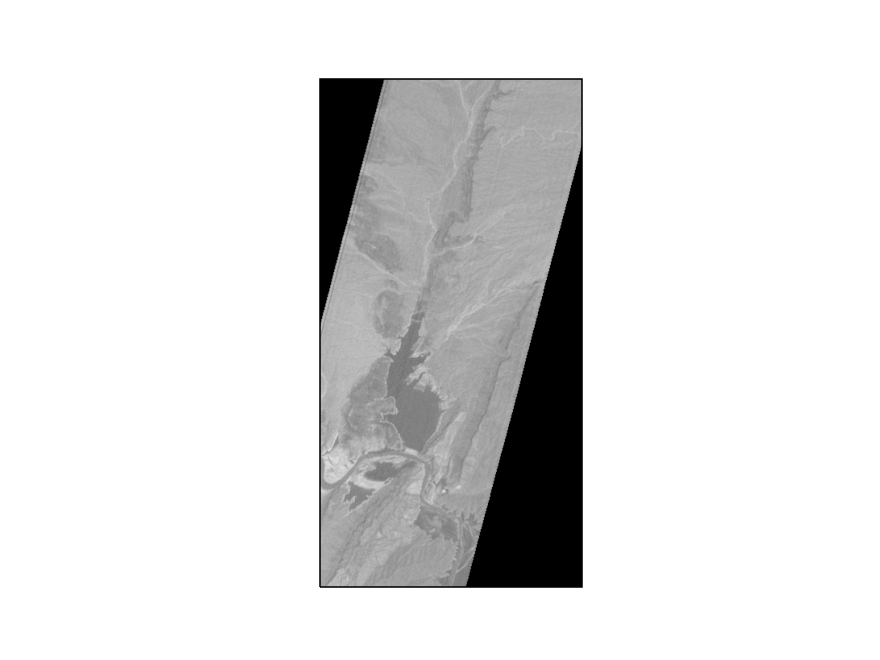

In [4]:
myCRS = ccrs.UTM(12)

plt.subplots(1, 1, subplot_kw=dict(projection=myCRS))
plt.imshow(ds['radiance'].loc[8], cmap='gray', transform=ccrs.UTM(12), extent=[xmin, xmax, ymin, ymax])

You can zoom in the image above to see the different features in the scene - you should see a large lake (Grand Wash) around halfway down the image, along with a large river just South of the lake (the Colorado River). In the Northern part of the image, you should also be able to see a number of canyons and cliffs - the geology in this area, as we'll see later on, is primarily sandstone/sedimentary rocks with some volcanics thrown in for flavor.

### 1.4 Displaying an RGB composite

To get a bit better overview, we can display an RGB composite image using bands 31 (), 20 (), and 11 (). Because hyperspectral images have much narrower bands than the images we've used in the past, we can actually choose a number of different combinations here and still have a similar picture - feel free to try out different band combinations. For a list of the bands and wavelengths, you can see **this file** in the `data` folder.

<IPython.core.display.Javascript object>


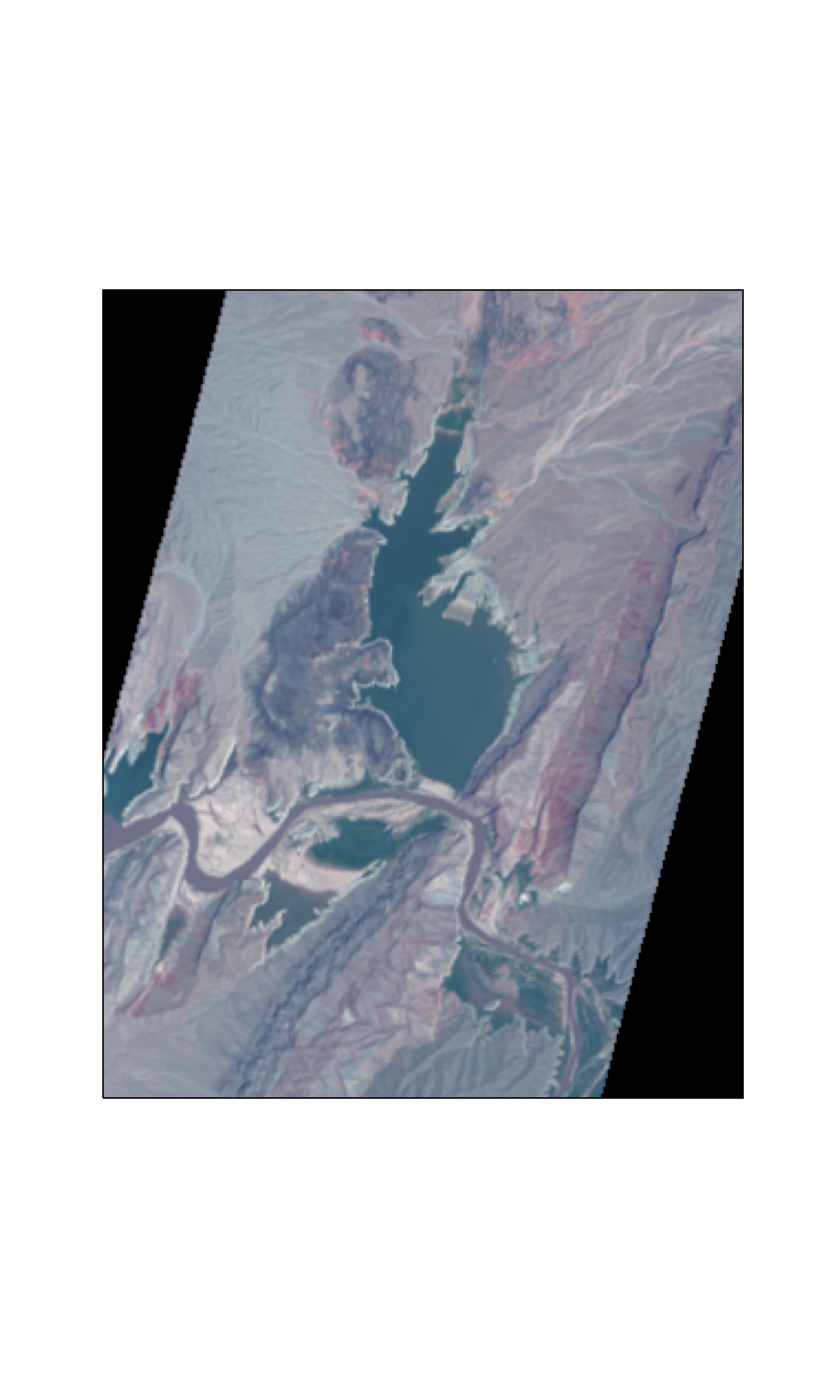

In [5]:
rgb_fig, ax = plt.subplots(1, 1, figsize=(6, 10), subplot_kw=dict(projection=myCRS))

ax = plot_rgb(ax, ds, [31, 20, 11], myCRS)

### 1.4 Plotting spectral curves
We can also see how the value of a single pixel varies by band, or wavelength. `xarray` provides two main ways to access these - we can either use the image index, or using the `sel()` method. In the first case, we'll see how to do this using the index. The next cell will plot the value of the radiance as a function of wavelength for the pixel in row 1950, column 500 (somewhere in the middle of the lake):

<IPython.core.display.Javascript object>


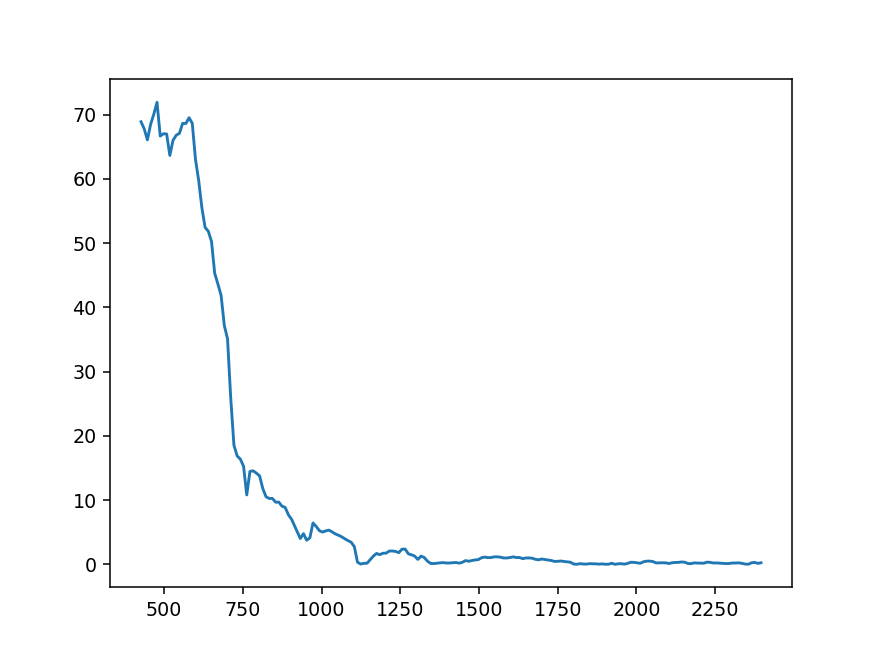

In [6]:
plt.figure()
plt.plot(ds['wavelength'], ds['radiance'][:, 1950, 500])

Notice how the radiance is significantly higher in the visible wavelengths (400-700 nm), dropping off substantially above about 600 or so nm - this indicates high radiance values in blue and green wavelengths, and significantly lower values in red and infrared wavelengths - much like we would expect for liquid water.

Row 1950, column 500 corresponds to `x`, `y` coordinates of (229800, 4011300). Rather than selecting the image coordinate, we can also select using the `x`,`y` coordinates for the image using the `sel` method. The following should then create the same plot as above:

<IPython.core.display.Javascript object>


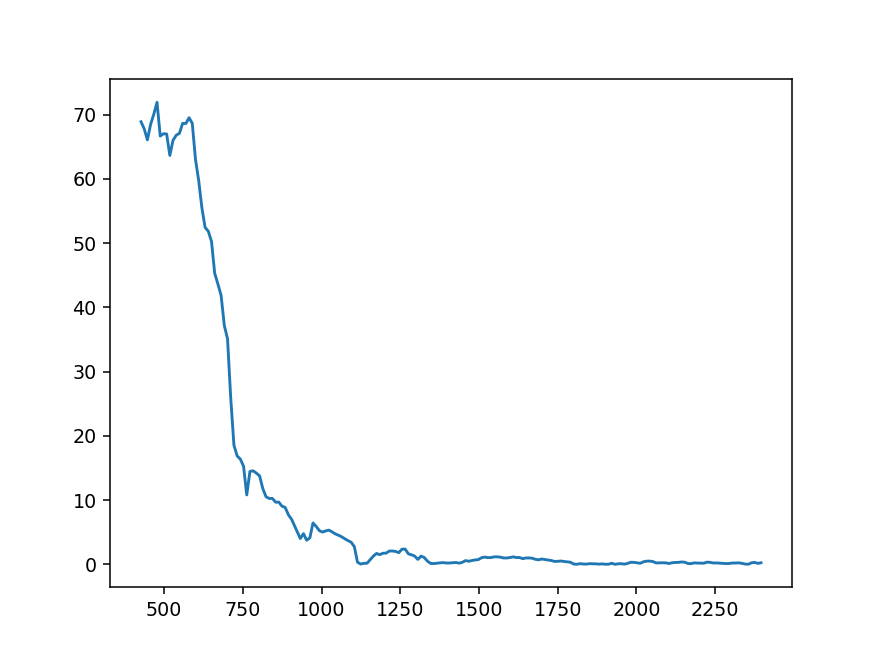

In [7]:
spec = ds['radiance'].sel(x=229800, y=4011300, method='nearest')

plt.figure()
plt.plot(ds['wavelength'], spec)

## 2 Atmospheric Correction
Now that we have a few ways to view our data, we can try to correct the radiance values for atmospheric effects. At shorter wavelengths (compared to the thermal infrared) like we have here, we tend to see more atmospheric scattering, increasing significantly towards shorter wavelengths. This is owing to the main ways that electromagnetic radiation scatters off of molecules and particles in the atmosphere, something we'll address in more detail next week.

### 2.1 Band Histogram
For now, we'll look at atmospheric correction using dark object subtract, something that was introduced (optionally) in the Week 1 practical. This technique is where we take the reflectance of an object (either an optically "dark" object, or objects in shadow) and subtract the observed radiance values for that object from the rest of the image. 

Rather than searching the image for a suitable object, we're going to use a percentile approach - taking the radiance value that is only brighter than 0.5% of the image. First, we can look at the histogram for Band 8:

<IPython.core.display.Javascript object>


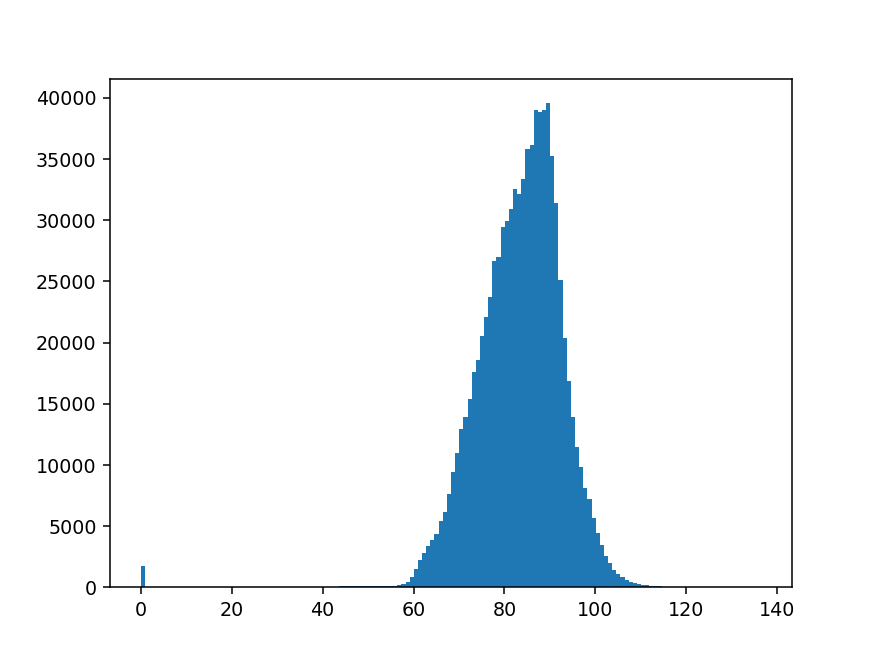

In [8]:
plt.figure()
data = ds['radiance'].loc[8].values.flatten() # this gives us a vector array that we can pass to plt.hist()

_ = plt.hist(data[data > 0], 150) # make sure to take only the values > 0,
# otherwise we'll end up with a ton of 0 (nodata) values

Note that there are a few values around 0, but most of the values seem to be between 60 and 120 W m<sup>-2</sup> sr<sup>-1</sup> µm<sup>-1</sup>. Based on this, a good estimate for the dark object radiance in this band would be around 60 W m<sup>-2</sup> sr<sup>-1</sup> µm<sup>-1</sup>. 

### 2.2 Finding the dark object value in each band
But, we don't want to have to do this by hand for every single band - instead, we'll use `numpy.percentile()` to calculate the value for us (this is, after all, one of the points of doing things programmatically).

In this cell, we'll first calculate the values for each next, we'll find the "dark object" value for each band using the value for the 0.5 percentile:

<IPython.core.display.Javascript object>


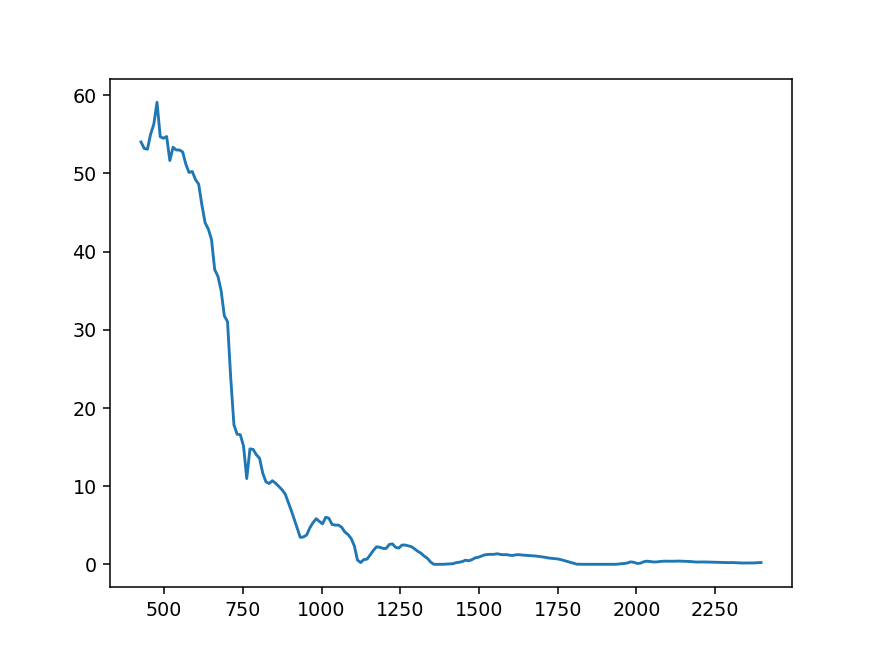

In [9]:
dark_obj = []
for b in ds['radiance']:
    # by selecting values where the value > 0, we ignore the nodata values
    dark_obj.append(np.percentile(b.values[b.values > 0], 0.5))

dark_obj = np.array(dark_obj)

plt.figure()
plt.plot(ds['wavelength'], dark_obj)

Notice how the value drops rapidly once we get through the visible wavelengths - again, this is because we expect to see the amount of atmospheric scattering drop exponentially as wavelength increases. We'll come back to these values again later when we look at individual reflectance curves.

## 3 Calculating reflectance

### 3.1 Solar radiance
Before we calculate reflectance, however, we need to know what the incident radiation is. In the `data` folder is a file called `solar_spectra.csv`, which contains values of extraterrestrial spectral irradiance downloaded from the [National Renewable Energy Laboratory](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html). These are provided as spectral irradiance in units of W m<sup>-2</sup> nm<sup>-1</sup>, which means that we need to multiply by 1000 (to convert from nm<sup>-1</sup> to µm<sup>-1</sup>), and divide by 4&pi; (to get values in W m<sup>-2</sup> sr<sup>-1</sup> µm<sup>-1</sup>) in order to compare with our satellite-derived values.

We'll also plot the dark object radiance and the radiance for our sample pixel in the lake, in order to see how they compare to the solar irradiance values.

<IPython.core.display.Javascript object>


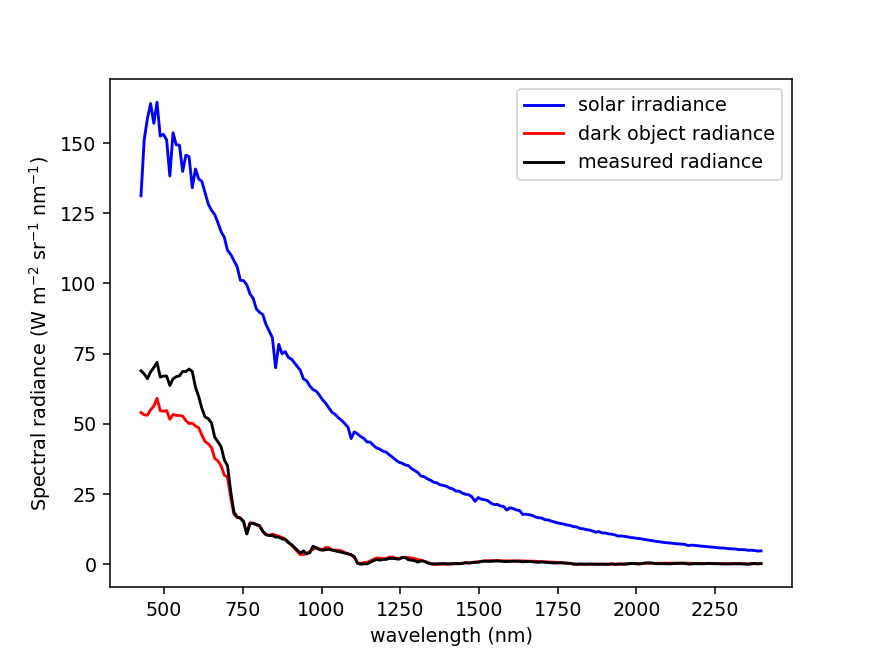

In [10]:
df = pd.read_csv('data/solar_spectra.csv')

etr_rad = df.etr * 1000 # convert to "per nanometer" values

plt.figure()
# note: in the line below, we divide by 4pi to get the value per steradian, to match with the units
plt.plot(df.wavelength, etr_rad / 4 / np.pi, 'b', label='solar irradiance')

plt.plot(ds['wavelength'], dark_obj, 'r', label='dark object radiance')
plt.plot(ds['wavelength'], spec, 'k', label='measured radiance')
plt.xlabel('wavelength (nm)')
plt.ylabel('Spectral radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')

plt.legend()

### 3.2 Calculating reflectance using COST

Now that we have the dark object radiance for each band and the solar irradiance, we can calculate the reflectance &rho;<sub>&lambda;</sub> using the corrected radiance (_L_<sub>&lambda;</sub> - _L_<sub>dark</sub>) and the solar irradiance (_L_<sub>sun</sub>):

![the COST equation](img/cost_eqn.png)

Where _d_ is the Earth-Sun distance in Astronomical Units and _&theta;_<sub>z</sub> is the solar zenith angle (to get this, we subtract the sun elevation angle found in the metadata, 65.098308, from 90).

For the scene we are using, acquired 22 June 2003, the Earth-Sun distance is 152040710.84 km, or about 1.0163294 AU.

<IPython.core.display.Javascript object>


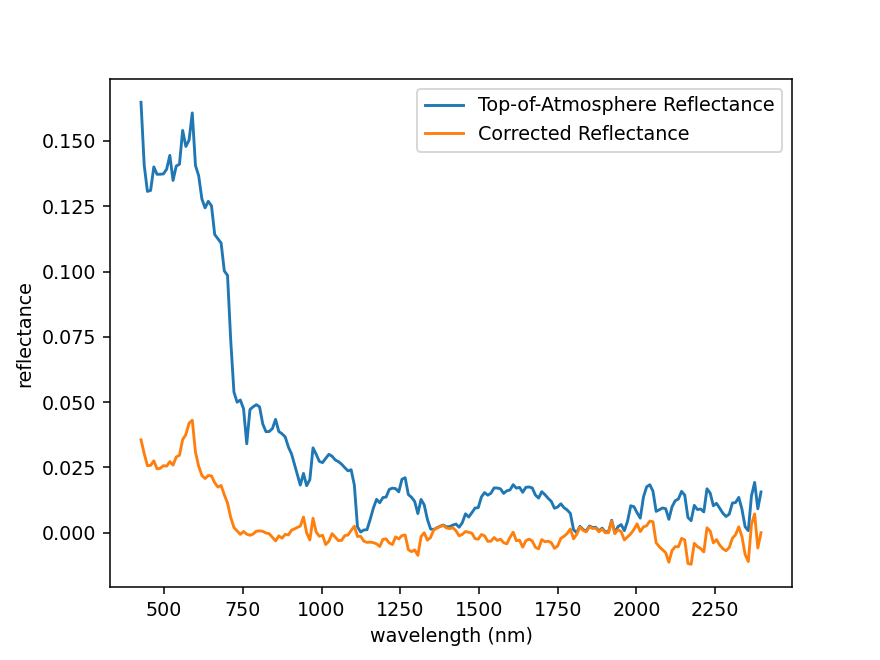

In [11]:
solar_zenith = np.deg2rad(90 - 65.098308) # solar zenith angle converted to radians
d = 152040710.84 / 149597870.700 # earth-sun distance converted to astronomical units

refl_toa = (spec * d**2 * np.pi) / (etr_rad * np.cos(solar_zenith)**2)
refl = ((spec - dark_obj) * d**2 * np.pi) / (etr_rad * np.cos(solar_zenith)**2)

plt.figure()
plt.plot(ds['wavelength'], refl_toa, label='Top-of-Atmosphere Reflectance')
plt.plot(ds['wavelength'], refl, label='Corrected Reflectance')

plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')

plt.legend()

Next, we'll define a helper function, `calculate_reflectance`, and apply it to each band's radiance values to get the reflectance in each band. Then, we'll add this variable to our dataset.

In [12]:
def calculate_reflectance(radiance, dark, etr, d, theta_z):
    return ((radiance - dark) * d**2 * np.pi) / (etr * np.cos(theta_z)**2)

reflectances = []
for i, band in enumerate(ds['radiance']):
    this_refl = calculate_reflectance(band.values, dark_obj[i], etr_rad[i], d, solar_zenith)
    this_refl[band.values == 0] = 0 # make sure that values that were 0 stay 0.
    this_refl[this_refl < 0] = 0.01 # set negative reflectance to a low value
    reflectances.append(this_refl)

# add a new variable to the dataset, reflectance, using the values calculated above
ds['reflectance'] = xr.DataArray(np.array(reflectances), dims=['band', 'y', 'x'])

Finally, we'll show the RGB image again, side-by-side with the atmospherically-corrected reflectance values. You should notice that the corrected image appears crisper, in addition to being significantly less blue - this is in part due to the increased scattering seen at shorter wavelengths.

<IPython.core.display.Javascript object>


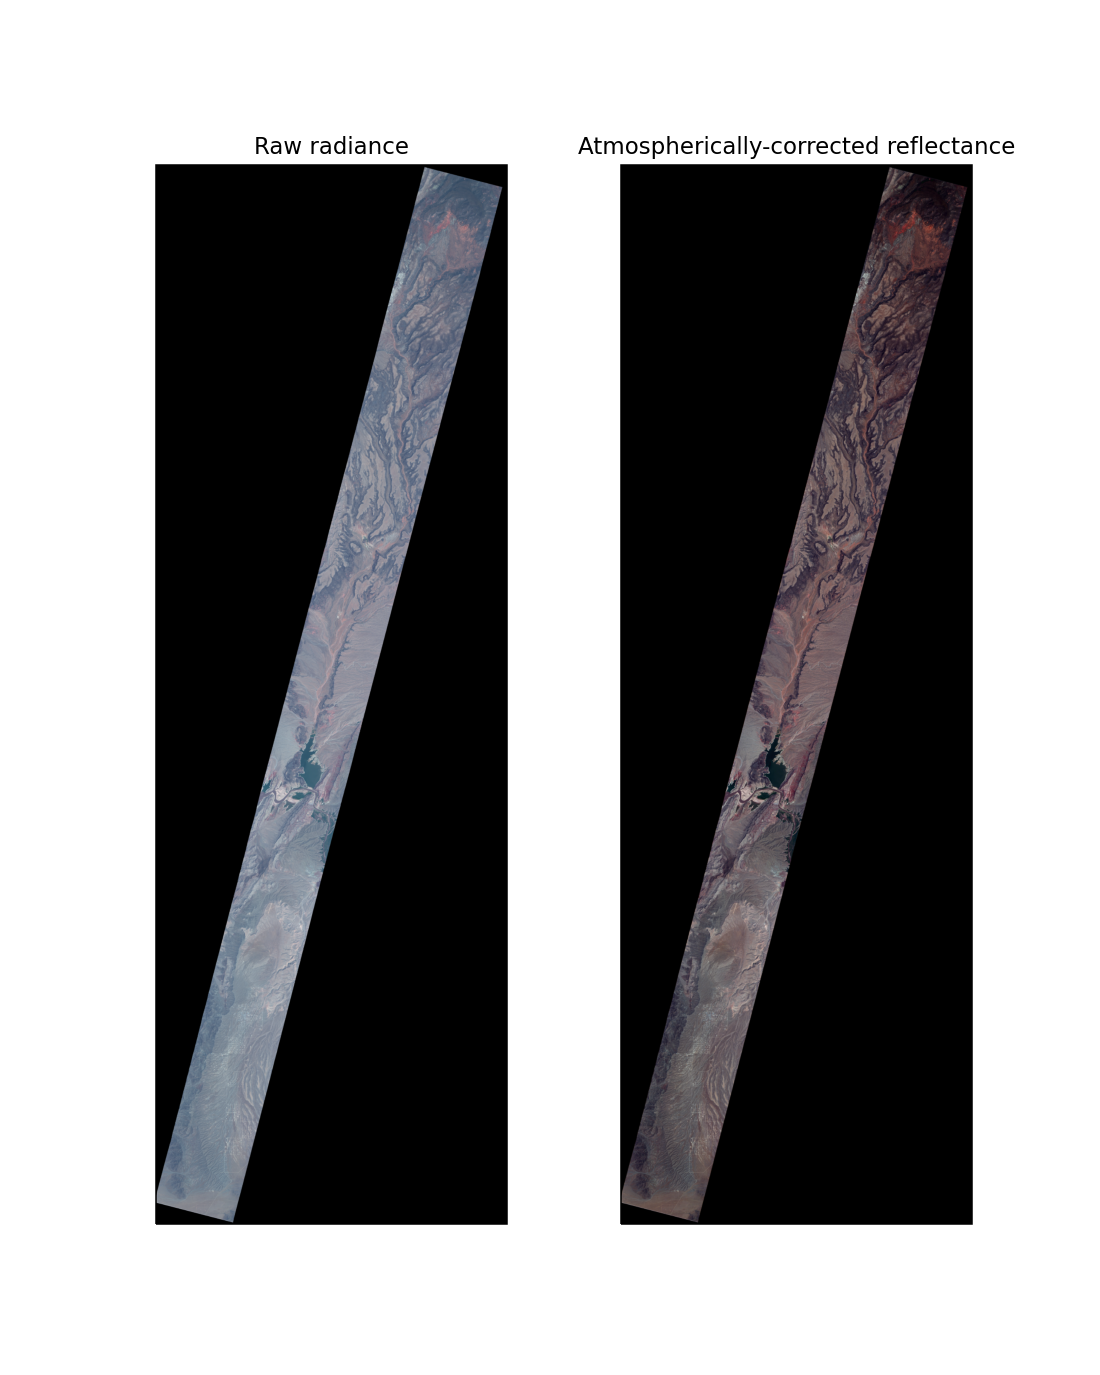

Text(0.5, 1.0, 'Atmospherically-corrected reflectance')

In [13]:
ref_fig, axs = plt.subplots(1, 2, figsize=(8, 10), subplot_kw=dict(projection=myCRS))

axs[0] = plot_rgb(axs[0], ds, [31, 20, 11], myCRS, variable='radiance')
axs[1] = plot_rgb(axs[1], ds, [31, 20, 11], myCRS, variable='reflectance')

axs[0].set_title('Raw radiance')
axs[1].set_title('Atmospherically-corrected reflectance')

## 4. Spectral Angle Mapping

### 4.1 Using a single end member
Next up, we'll see how we can calculate the angle between the spectral vector for our example pixel and water. We'll start by loading our spectral library samples, then calculate the spectral angle &alpha; according to the formula:

![spectral angle mapping formula](img/sam_eqn.png)

For this, we'll use [Spectral Python](https://www.spectralpython.net/) (SPy), a python module for processing hyperspectral data. In addition to spectral angle mapping, SPy also has a number of algorithms that we have discussed, including minimum noise fraction (MNF) and principal component analysis (PCA), and it also includes tools for querying the ECOSTRESS Spectral Library.

In [14]:
# load the spectral library values that have been re-sampled to the same wavelengths as the EO-1 image.
spectral_library = pd.read_csv('data/spectral_library.csv')

water_angles = spy.spectral_angles(ds['reflectance'].values.transpose([1, 2, 0]), 
                                   spectral_library['water'].values.reshape(1, -1))

C:\Users\simon\anaconda3\envs\env-703-wk2\lib\site-packages\spectral\algorithms\algorithms.py:1356: RuntimeWarning: invalid value encountered in true_divide
  dots = np.clip(dots / norms[:, :, np.newaxis], -1, 1)


We can now look at the spectral angle for each pixel - we'll focus on the lake so we can get an idea of how well it works:

<IPython.core.display.Javascript object>


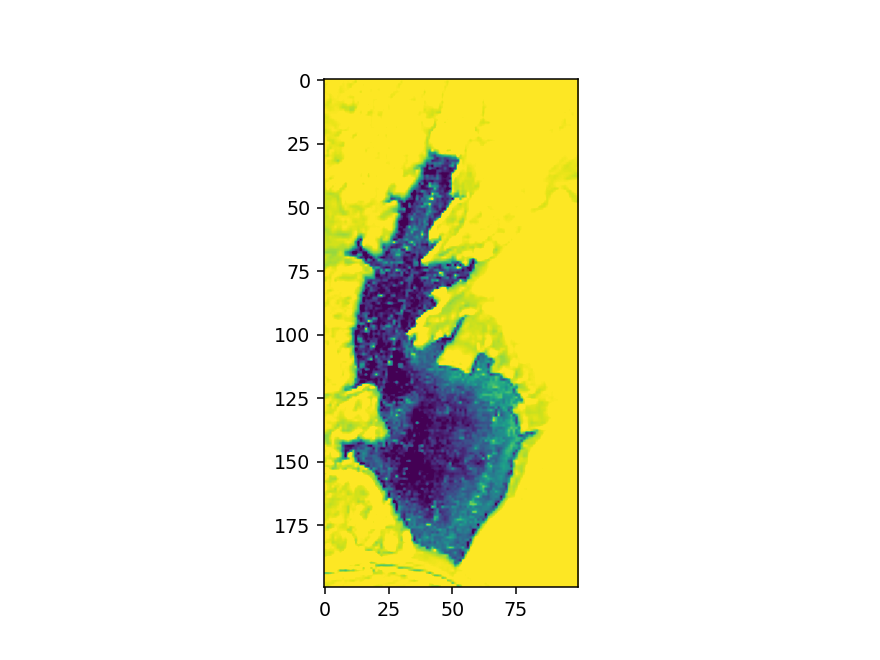

In [15]:
plt.figure()
plt.imshow(water_angles[1800:2000, 450:550], vmin=0.5, vmax=0.8)
# plt.imshow(angle)

You should see that the water has a comparatively small angle (dark colors), while the land has a typically larger angle - overall, it seems to have worked as we might expect, although it does appear somewhat noisy.

With one spectral signature like this example, we could choose a threshold angle for binary classification - pixels with an angle less than the given threshold would be classified as water, and pixels with an angle larger than the given threshold would be classified as 'not water'

To see why the results for this example might be somewhat noisy, let's look at the reflectance spectra for a few example pixels from the lake:

<IPython.core.display.Javascript object>


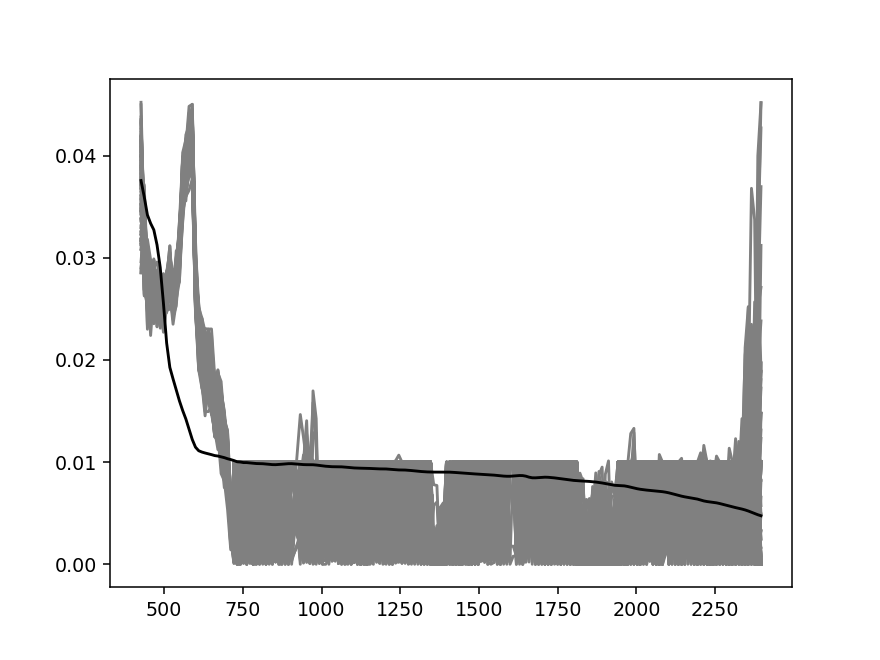

In [16]:
# we can also select a range of pixels using xarray
# in this example, we're selecting based on a range of x and y values
test_pixels = ds['reflectance'].sel(x=np.linspace(229300, 229600, 10),
                                    y=np.linspace(4011800, 4012100, 10), method='nearest')

plt.figure()
plt.plot(ds['wavelength'], test_pixels.values.reshape(194, -1), '0.5')

plt.plot(ds['wavelength'], spectral_library['water'].values, 'k')

In the example above, we can see that there's quite a bit of noise in our reflectance spectra - this is contributing to the noise we can see in the spectral angle results.

### 4.2 Multiple end members

With additional reference spectra (end members), we can find which end member each pixel is 'closest' to. With `spectral.spectral_angles()`, we can use as many end members as we have data for. In the next example will do this for all of our reference spectra:

In [17]:
print(spectral_library.columns[1:])

end_members = spectral_library.columns[1:]

# spectral_angles expects the data to have a shape (rows, columns, bands), while our data are (bands, rows, columns)
# we also need to transpose our spectral library data so that the rows correspond to each end member
all_angles = spy.spectral_angles(ds['reflectance'].values.transpose([1, 2, 0]), 
                                 spectral_library[end_members].values.transpose())

Index(['water', 'ponderosa', 'gypsum', 'basalt', 'limestone', 'sandstone',
       'siltstone', 'shale'],
      dtype='object')


C:\Users\simon\anaconda3\envs\env-703-wk2\lib\site-packages\spectral\algorithms\algorithms.py:1356: RuntimeWarning: invalid value encountered in true_divide
  dots = np.clip(dots / norms[:, :, np.newaxis], -1, 1)


In [18]:
spectral_library[end_members].values.transpose().shape

(8, 194)

Using `numpy.argmin()`, we can then display an image where the value of each pixel corresponds to the end member with the smallest angle for each pixel - in other words, the best match.

<IPython.core.display.Javascript object>


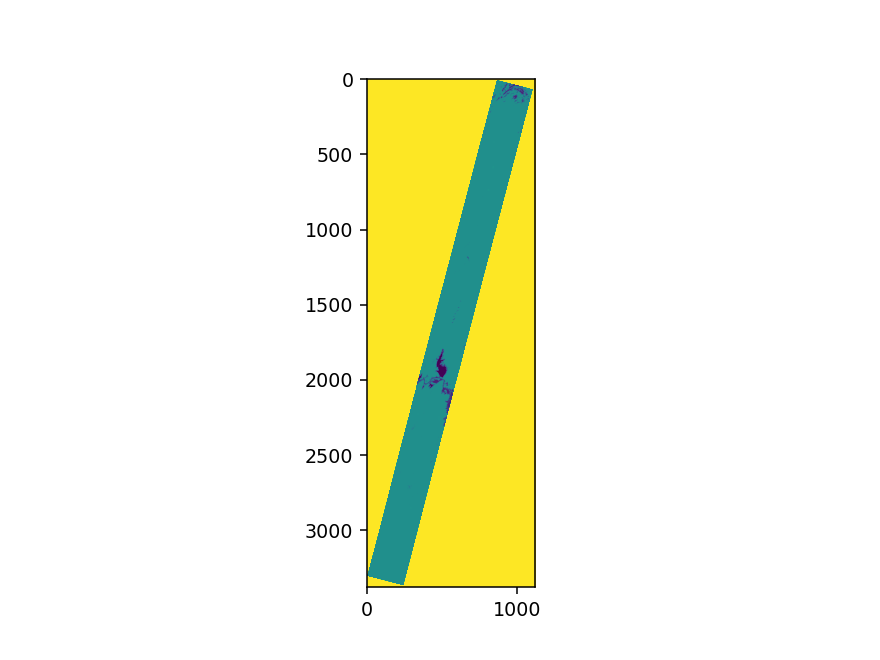

In [19]:
plt.figure()

# this will tell us which end member has the smallest spectral angle for each pixel
best_match = np.argmin(all_angles, axis=2)

# this will set the nodata pixels to 255, so that we can safely ignore them.
best_match[ds['reflectance'].loc[8] == 0] = 255

plt.imshow(best_match, vmax=10)

Here, we can see that the Lake has a fairly uniform value of 0, indicating that we've done a good job classifying the water. We can also see that in the northern part of the image, we have a number of areas where we've successfully picked out the stands of ponderosa pines (value of 1). While most of the image has been classified as sandstone, we know from the [geologic maps](http://data.azgs.az.gov/geologic-map-of-arizona/) of the area that this isn't completely correct - we should see areas of basalts and other types of bedrock.

To get a better classification of the image, we would want to be sure to pick out additional end members, and possibly even include multiple samples - remember that small differences in grain size or chemical composition can have a large impact on the spectral signature.

While these results aren't bad for an initial attempt, the image is still relatively noisy. To help reduce the impact of the noise in the data, we might also consider using the minimum noise fraction or a similar data reduction technique.

### 4.3 Exporting the results

As a last step, we'll export this classified image to a raster file:

In [20]:
import rasterio as rio

with rio.open('EO1H0380352003173110PF_RGB.tif', 'r') as src:
    profile = src.profile
    profile.update({'dtype': np.uint8, 'count': 1, 'nodata': 255})
    with rio.open('sam_classification.tif', 'w', **profile) as dst:
        dst.write(best_match.astype(np.uint8), 1)

You should be able to load the classified raster in a GIS software such as ArcGIS Pro or QGIS, and calculate the area and percent coverage of each end member in the image.

That will wrap us up for this week's practical - as mentioned, there are a number of additional algorithms available from `spectral` - for a full list, check out the full [API documentation](https://www.spectralpython.net/class_func_ref.html).